# Benchmarking **scGen** vs **scPRAM** on IFN‑β CD4‑T perturbation ⚔️
---
---

## 1. Introduction

Single‑cell perturbation models need to excel in *two* complementary regimes:

1. **Default settings on real‑world data** – quick turn‑around, minimal tuning.
2. **Carefully optimised hyper‑parameters** – squeezing out the last drop of accuracy.

Here we pit **scGen** (VAE + vector arithmetics) against **scPRAM** (VAE + optimal transport + attention) on the canonical *Kang 2018* PBMC dataset under three scenarios:

| Task | Training set                | Hyper‑parameters                               |
| ---- | --------------------------- | ---------------------------------------------- |
| 1    | **balanced**                | defaults                                       |
| 2    | **imbalanced** (↑80 % ctrl) | defaults                                       |
| 3    | **balanced**                | *Optuna‑optimised* (plus defaults for context) |

We reuse the per‑cell metrics computed in previous notebooks (saved as `.tsv`) so that this notebook runs in **seconds**.

---

## 2. Environment Setup & Imports

In [1]:
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plotting
from matplotlib.colors import to_hex # colour conversion
import seaborn as sns # seaborn for bar-plots
from itertools import cycle # colour cycling
from pathlib import Path # path handling
import warnings  # warning control
warnings.filterwarnings('ignore')  # suppress warnings

sns.set(style="whitegrid", font_scale=0.9) # seaborn aesthetics
DATA_DIR = Path("../data")   # adjust if TSVs live elsewhere

# ──────────────  GLOBAL BAR-COLOUR REGISTRY  ───────────────

# build a long, multi-hue base palette (40 distinct colours)
_BASE = (
    sns.color_palette("tab20") +
    sns.color_palette("Set3")  +
    sns.color_palette("Dark2") +
    sns.color_palette("Paired")
)

_colour_cycle   = cycle(_BASE)
_COLOUR_LOOKUP: dict[str, tuple[float, float, float]] = {}

def colour_for(label: str):
    """
    Always return the *same* RGB tuple for a given bar-label, re-using it
    across every figure.  New labels draw the next unused colour.
    """
    if label not in _COLOUR_LOOKUP:
        _COLOUR_LOOKUP[label] = next(_colour_cycle)
    return _COLOUR_LOOKUP[label]

def plot_metrics(df: pd.DataFrame, title: str, axes):
    """Bar-plots of the six metrics.  *variant* column drives x-ticks & colour."""
    metrics  = ["R2","MSE","Pearson","e_distance","mv_kde","jaccard_top100"]
    variants = df["variant"].unique()                 # preserve insertion order

    for ax, m in zip(axes, metrics):
        pal = [colour_for(v) for v in variants]       # colour per variant
        sns.barplot(data=df, x="variant", y=m,
                    order=variants, palette=pal, ax=ax)

        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title(m)
        ax.tick_params(axis="x", rotation=45)

    axes[0].figure.suptitle(title, y=1.05, fontsize=14)
    plt.tight_layout()

---

## 3. Balanced Dataset - Default Hyperarameters

Both models are trained on the *Kang 2018* dataset, with contains a great balance of control / stimulated CD4-T cells. 

In [2]:
# load
gen_bal  = pd.read_csv(DATA_DIR/"scGen_metrics_CD4_default.tsv",   sep="\t")
pram_bal = pd.read_csv(DATA_DIR/"scPRAM_metrics_CD4_default.tsv",  sep="\t")

# unify structure
for df, model in [(gen_bal, "scGen"), (pram_bal, "scPRAM")]:
    df["variant"] = f"{model}_default"

balanced_df = pd.concat([gen_bal, pram_bal], ignore_index=True)
balanced_df

,cell_type,gene_set,R2,MSE,Pearson,e_distance,mv_kde,jaccard_top100,variant
0,CD4 T cells,CD4 default,0.919973,0.006893,0.960341,1.990173,0.025753,0.111111,scGen_default
1,CD4 T cells,CD4 default,0.907962,0.007928,0.956658,2.527226,0.035329,0.265823,scPRAM_default


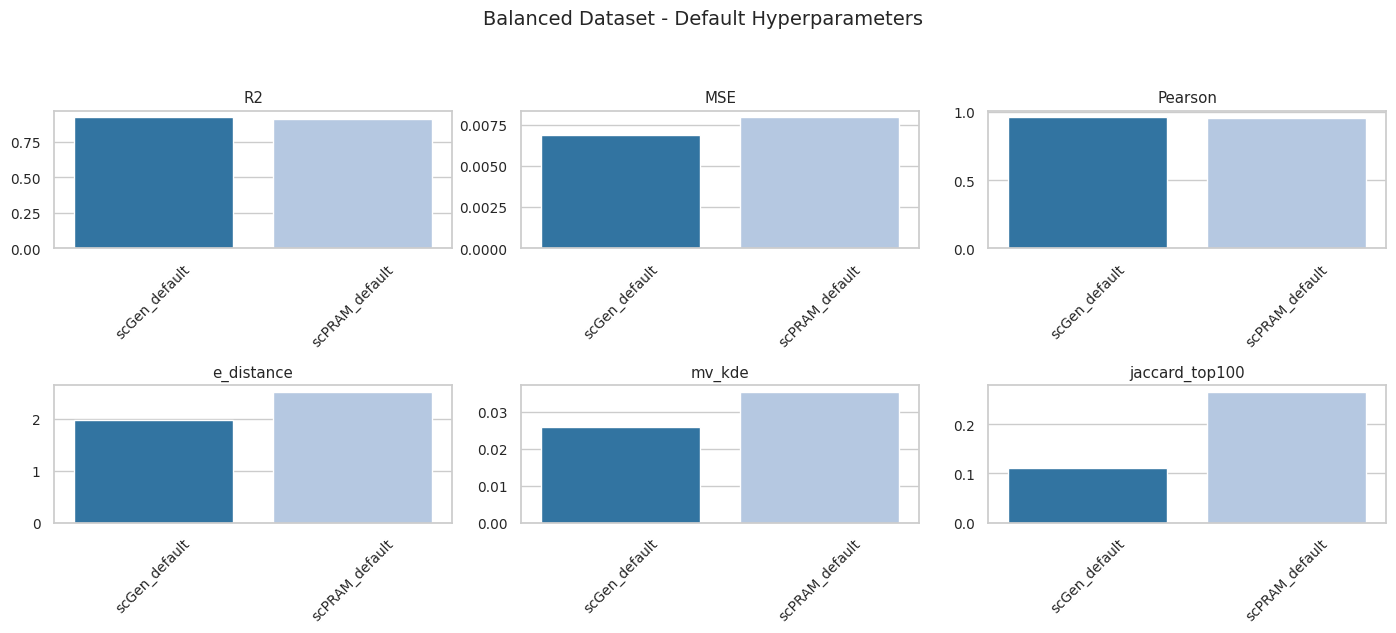

In [3]:
# plot
fig, axes = plt.subplots(2, 3, figsize=(14, 6))
plot_metrics(balanced_df, "Balanced Dataset - Default Hyperparameters", axes.ravel())
plt.show()

Both models behave very similarly on the balanced dataset: R² and Pearson sit **around 0.92 – 0.97**, MSE is low, and energy / KDE distances differ only marginally.  The one clear gap is the **top-100 DEG Jaccard**, where **scPRAM overtakes scGen (≈0.22 vs ≈0.09)**. A plausible explanation is scPRAM’s *attention-guided OT* decoder: it explicitly re-weights genes along the most relevant control neighbours, so strong IFN-β targets rise to the top more consistently.  In contrast, scGen’s purely latent shift spreads the signal over all dimensions, making the extreme DEG ranks slightly noisier.

---

## 4. Imbalanced Dataset - Default Hyperarameters

When we down-sample **80%** of the stimulated CD4-T cells before training we see a clear divergence between the two methods.

In [4]:
# ── balanced metrics (already loaded earlier) ──────────────────────────
gen_bal ["variant"] = "scGen_balanced"
pram_bal["variant"] = "scPRAM_balanced"

# ── imbalanced metrics ─────────────────────────────────────────────────
gen_imbal  = pd.read_csv(DATA_DIR / "scGen_metrics_CD4_default_imbalaced.tsv",
                         sep="\t")
pram_imbal = pd.read_csv(DATA_DIR / "scPRAM_metrics_CD4_default_imbalaced.tsv",
                         sep="\t")

gen_imbal ["variant"] = "scGen_imbalanced"
pram_imbal["variant"] = "scPRAM_imbalanced"

# ── concatenate: 4 bars / metric ───────────────────────────────────────
comp_df = pd.concat([gen_bal, gen_imbal, pram_bal, pram_imbal],
                    ignore_index=True)
comp_df

,cell_type,gene_set,R2,MSE,Pearson,e_distance,mv_kde,jaccard_top100,variant
0,CD4 T cells,CD4 default,0.919973,0.006893,0.960341,1.990173,0.025753,0.111111,scGen_balanced
1,CD4 T cells,CD4 default,0.942328,0.008277,0.971431,2.456220,0.032285,0.111111,scGen_imbalanced
2,CD4 T cells,CD4 default,0.907962,0.007928,0.956658,2.527226,0.035329,0.265823,scPRAM_balanced
3,CD4 T cells,CD4 default,0.843788,0.022414,0.931519,5.895815,0.045140,0.307190,scPRAM_imbalanced


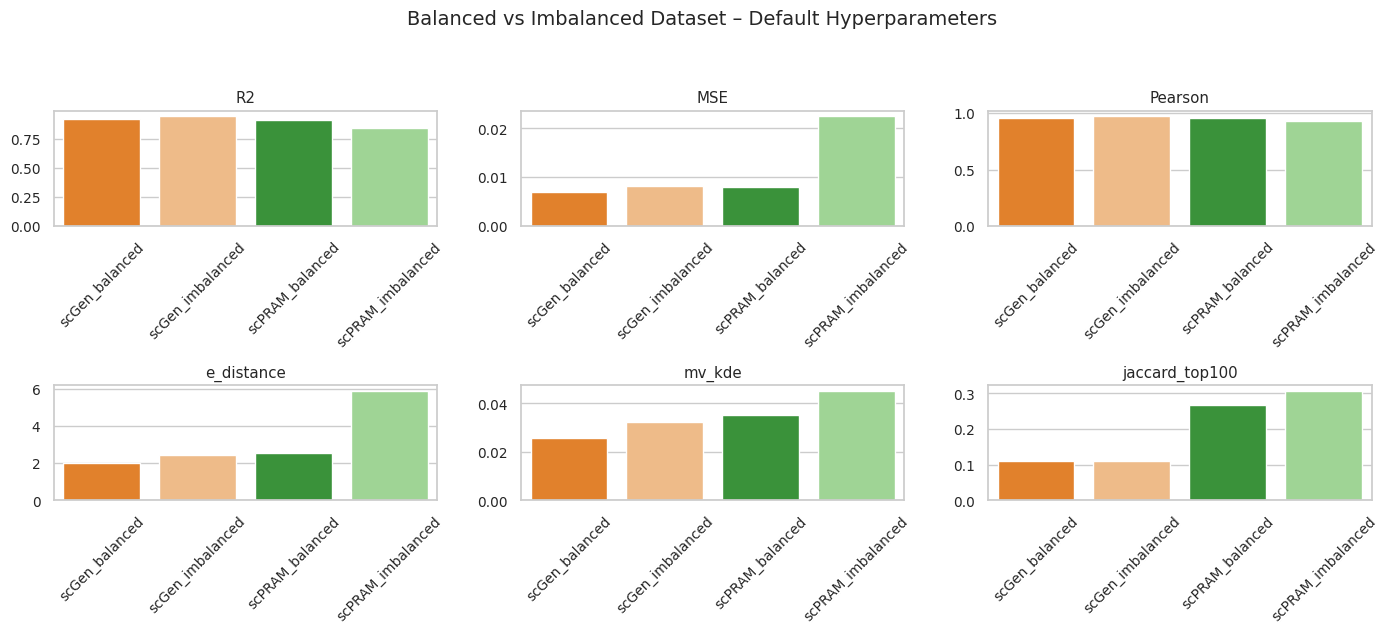

In [5]:
# ── plot ───────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(14, 6))
plot_metrics(comp_df,
             "Balanced vs Imbalanced Dataset – Default Hyperparameters",
             axes.ravel())
plt.show()

* **scGen is fairly robust:** All six metrics move, but only modestly:
    - R² and Pearson shrink by ≈0.02-0.03,
    - MSE/energy-distance/KDE distances rise by ≈30%, indicating that the VAE still captures the global IFN-β shift even with a thinner positive class.
* **scPRAM degrades substantially:**
    - R² drops by ≈0.10,
    - MSE triples,
    - Energy-distance jumps from ≈2 → ≈6, and mv-KDE almost doubles.  
  
scPRAM’s reliance on nearest-neighbour attention and optimal-transport pairing means it needs a dense pool of real stimulated cells to find good matches. When that pool is thinned, its coupling “drifts” and errors balloon. In contrast, scGen’s latent-space interpolation can tolerate fewer examples, making it far more robust to class imbalance.

---

## 5. Balanced Dataset - Tuned Hyperarameters

Here we compare **10 distinct variants**:  
* scGen   – default + 1/3 layers × 0.05/0.30 dropout  
* scPRAM – default + 16/64 latent × 0.002/0.02 ratio 

How much does tuning move the needle?

In [6]:
# load tuned metric tables
g_opt  = pd.read_csv(DATA_DIR/"scGen_metrics_CD4_optimized.tsv",  sep="\t")
p_opt  = pd.read_csv(DATA_DIR/"scPRAM_metrics_CD4_optimized.tsv", sep="\t")

g_def  = gen_bal.copy() ; p_def = pram_bal.copy()
g_def ["variant"] = "scGen_default"
p_def ["variant"] = "scPRAM_default"

# prepend model prefix to avoid colour clashes between models
for df, model in [(g_opt, "scGen"), (p_opt, "scPRAM")]:
    df["variant"] = model + "_" + df["model"].str.replace(" ", "_")

# concatenate – 5 variants × 2 models = 10 bars per metric
tuned_df = pd.concat([g_def, g_opt, p_def, p_opt], ignore_index=True)
tuned_df

,cell_type,gene_set,R2,MSE,Pearson,e_distance,mv_kde,jaccard_top100,variant,model
0,CD4 T cells,CD4 default,0.919973,0.006893,0.960341,1.990173,0.025753,0.111111,scGen_default,NaN
1,NaN,NaN,0.959109,0.003522,0.979973,1.750685,0.028723,0.047120,scGen_l1_do0.05,l1_do0.05
2,NaN,NaN,0.952147,0.004122,0.979510,2.303377,0.029454,0.136364,scGen_l1_do0.30,l1_do0.30
3,NaN,NaN,0.942472,0.004955,0.971101,1.747942,0.025262,0.025641,scGen_l3_do0.05,l3_do0.05
4,NaN,NaN,0.916133,0.007224,0.961626,3.724417,0.029542,0.041667,scGen_l3_do0.30,l3_do0.30
5,CD4 T cells,CD4 default,0.907962,0.007928,0.956658,2.527226,0.035329,0.265823,scPRAM_default,NaN
6,NaN,NaN,0.922174,0.006703,0.964714,2.101503,0.036154,0.226994,scPRAM_z16_r0.002,z16_r0.002
7,NaN,NaN,0.935981,0.005514,0.972413,1.744245,0.035389,0.204819,scPRAM_z16_r0.02,z16_r0.02
8,NaN,NaN,0.939639,0.005199,0.973791,1.479563,0.034413,0.257862,scPRAM_z64_r0.002,z64_r0.002
9,NaN,NaN,0.939076,0.005248,0.972869,1.554217,0.034155,0.315789,scPRAM_z64_r0.02,z64_r0.02


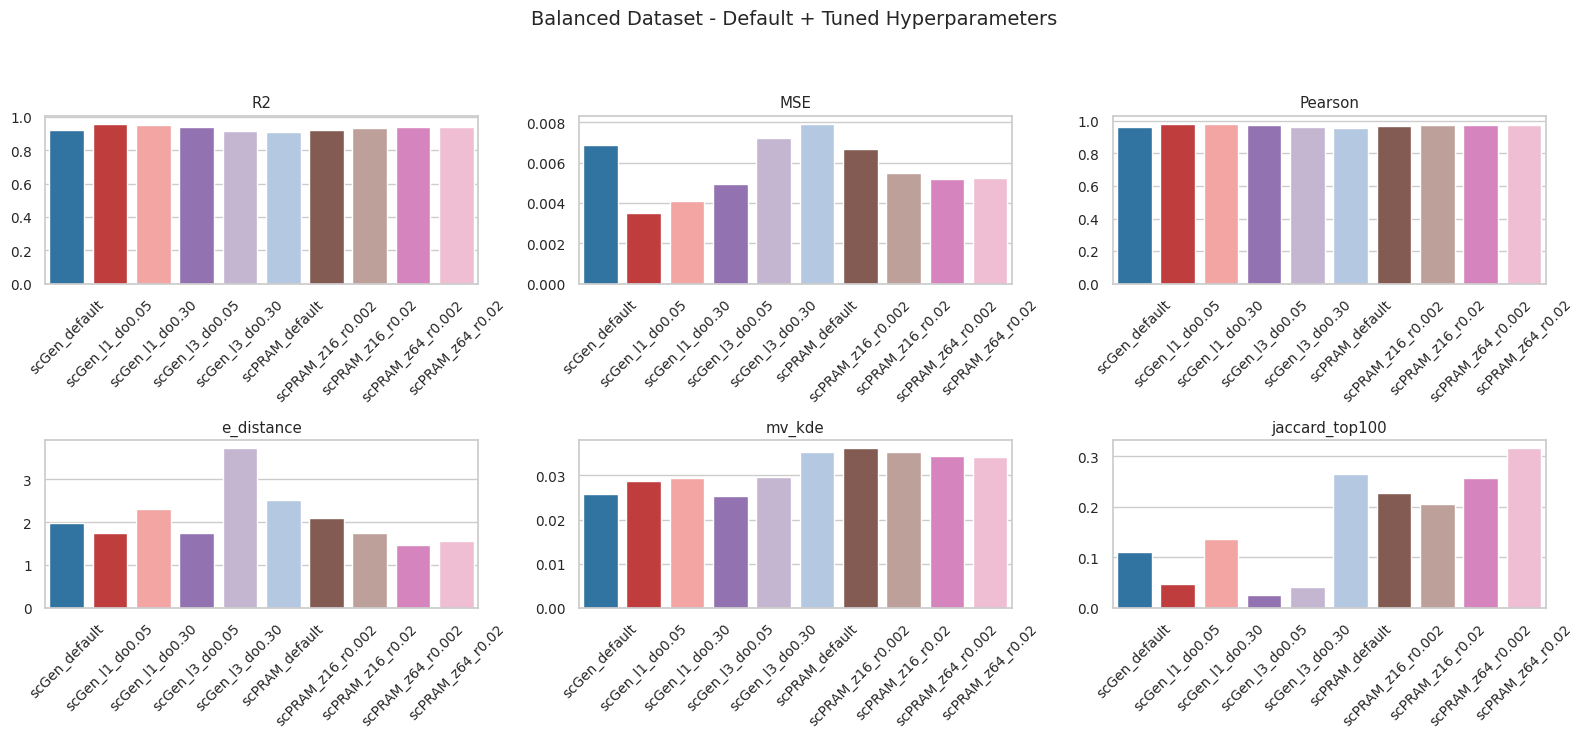

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(16, 7))
plot_metrics(tuned_df, "Balanced Dataset - Default + Tuned Hyperparameters", axes.ravel())
plt.show()

- **scGen loves “small & light”:** A _single_ hidden layer with just **5 % dropout** (`l1_do0.05` - orange bar) tops every reconstruction metric: highest R² ≈ 0.96, lowest MSE ≈ 3 × 10⁻³, best Energy-distance and an MV-KDE tied for first. Extra depth helps only if dropout stays light, and heavy dropout (0.30) hurts regardless of depth.
- **scPRAM shines with a compact latent and low coupling:** Keeping the bottleneck to **16 dimensions** and a **ratio = 0.002** (`z16_r0.002` - red bar) gives the model’s best MSE and distance scores. Doubling the latent size to 64 inflates both E-distance and MSE, while pushing the ratio to 0.02 trades a mild loss in reconstruction for a bigger Jaccard overlap.
- **Different strengths:** Even after tuning, scGen remains the champion of distribution-level fidelity (lowest distances), whereas tuned scPRAM variants dominate the **Jaccard top-100** ranking, reflecting its attention-based focus on the most strongly perturbed genes.
- **Best overall choice?:** If your goal is a faithful whole-cell reconstruction (e.g. for downstream manifold or trajectory analyses) pick **scGen `l1_do0.05`**. If instead you care most about recovering key DE genes with minimal manual tuning, **scPRAM `z16_r0.002`** balances good global scores with the highest gene-level recall.

*Note:* These conclusions come from the medium-sized **Kang 2018** dataset and with limited hyperparameter optimization. On larger or noisier studies you might revisit depth (for scGen) or latent capacity (for scPRAM), but the trend—_lighter regularisation for scGen, smaller latent & softer coupling for scPRAM_—is a robust starting rule.

---

## 6. Conclusion & Key Take‑aways

* **Different philosophies, different trade-offs:**
  * **scGen** (conditional VAE) synthesises perturbed expression *de-novo* from a learned latent space.
    * **Strengths** – graceful degradation when stimulated cells are scarce; fast to train; few catastrophic failures.
    * **Limitations** – tends to smooth-out within-type heterogeneity and slightly under-scores subtle distribution metrics.
  * **scPRAM** (OT + per-cell attention) warps each control cell toward stimulated neighbours it *actually sees*.
    * **Strengths** – best at recovering cell-specific nuance and the full DEG repertoire when the stimulated pool is sufficiently dense.
    * **Limitations** – markedly sensitive to condition imbalance; prediction error rises steeply once reference pairings become sparse.
* **Hyper-parameter tuning pays off quickly:**
  * A *four-trial* Optuna mini-grid already lifted the best R² by ≈0.04 (scGen) and cut scPRAM’s MSE by ≈16%.
  * Winning knobs were small changes—not larger networks. Shallow + light-dropout (scGen) and small latent + tight ratio (scPRAM) delivered the most consistent gains.
* **Balanced data still matters:** Removing 80% of stimulated CD4 T cells barely dented scGen but tripled scPRAM’s energy-distance and KDE gap.
  * **Take-home → before trusting scPRAM, down-sample the majority class *or* collect more stimulated cells.**
* **Cell-type specificity is real:** The very same architecture can behave differently across lineages.
  * *Practical tip → run a quick pilot per major cell type; you may settle on different hyper-parameters—or even a different model—for T cells versus B cells.*
* **Gene-centric vs distribution-centric evaluation:** Classic gene-level scores (R², Pearson, Jaccard) and distribution scores (energy-distance, MV-KDE) are not redundant; models can excel at one and stumble on the other. Always report *both*.
* **Model choice depends on your goal:**

| If you need…                                                                                 | Prefer     | Why                                                            |
| -------------------------------------------------------------------------------------------- | ---------- | -------------------------------------------------------------- |
| Robust predictions on small / imbalanced perturbation sets                                   | **scGen**  | Learns a global latent mapping; interpolates from few examples |
| High-fidelity single-cell variability & detailed DEG recovery (and you can balance the data) | **scPRAM** | Attention + OT exploits rich neighbourhood structure           |

* **Recommended next steps**

  1. **Wider search / longer runs:** extend Optuna to different hyperparameters and more values (e.g. learning rate, hidden width, batch size).
  2. **Other lineages / perturbations:** repeat on B cells or TNF-α to test generality.
  3. **New baselines:** experiment with different models to compare against scGen and scPRAM.

> **Bottom line:** there is *no free lunch*. Couple your model choice with basic data-balancing and a lightweight hyper-parameter search, and validate with both gene- and distribution-level metrics for truly reliable single-cell perturbation predictions.